# Orders

#### Investigating the orders, and their associated review score.

we will create one single data table containing **all our orders with some engineered statistics for them as additional columns.**

Creating the following DataFrame, which will be very handy for the modeling phase.

  - `order_id` (_str) the id of the order_
  - `wait_time` (_float) the number of days between order_date and delivered_date_
  - `expected_wait_time` (_float) the number of days between order_date and estimated_delivery_date_
  - `delay_vs_expected` (_float) if the actual delivery date is later than the estimated delivery date, returns the absolute number of days between the two dates, otherwise return 0_
  - `order_status` (_str) the status of the order_
  - `dim_is_five_star` (_int) 1 if the order received a five_star, 0 otherwise_
  - `dim_is_one_star` (_int) 1 if the order received a one_star, 0 otherwise_
  - `review_score`(_int) from 1 to 5_
  - `number_of_product` (_int) number of products that the order contains_
  - `number_of_sellers` (_int) number of sellers involved in the order_
  - `price` (_float) total price of the order paid by customer_
  - `freight_value` (_float) value of the freight paid by customer_
  - `distance_customer_seller` (_float) the distance in km between customer and seller_


DB Schema: https://kitt.lewagon.com/db/23825

In [50]:
# Auto reload imported module everytime a jupyter cell is executed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import olist data
from olistdash.data import Olist
olist=Olist()
data=olist.get_data()
matching_table = olist.get_matching_table()

## Code `order.py`

In [4]:
orders = data['orders'].copy() # to be sure not to modify the `data` variable
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


#### Filter delivered orders

In [5]:
orders = orders.query("order_status=='delivered'").copy()

## 1. def get_wait_time():
Return a dataframe with `[order_id, wait_time, expected_wait_time, delay_vs_expected, order_status]`

#### ⁉ ... Checking type of objects in "time columns"

In [6]:
print(type(orders['order_delivered_customer_date'][1]))
print(type(orders['order_estimated_delivery_date'][1]))
print(type(orders['order_purchase_timestamp'][1]))

<class 'str'>
<class 'str'>
<class 'str'>


#### ❕❗ As they are 'str' it is needed to convert them to pandas.datetime

#### handling datetime

In [7]:
# converting column ['order_delivered_customer_date'] from "str" to pandas.datetime
orders.loc[:, 'order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
# converting column ['order_estimated_delivery_date'] from "str" to pandas.datetime
orders.loc[:, 'order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
# converting column ['order_purchase_timestamp'] from "str" to pandas.datetime
orders.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

#### ⁉ ... Checking again type of objects in "time columns"

In [8]:
print(type(orders['order_delivered_customer_date'][1]))
print(type(orders['order_estimated_delivery_date'][1]))
print(type(orders['order_purchase_timestamp'][1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### 👌🆗 Now it is possible to procced

### 1.1 Computing ["delay_vs_expected"]

In [9]:
# Creating new column ['delay_vs_expected']
orders.loc[:, 'delay_vs_expected'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']) / np.timedelta64(24, 'h')

In [10]:
# TEST
orders['delay_vs_expected'][1]

5.355729166666666

##### Analize new column:

In [11]:
orders['delay_vs_expected'].describe()

count    96470.000000
mean        11.178126
std         10.184354
min       -188.975081
25%          6.389815
50%         11.948102
75%         16.244065
max        146.016123
Name: delay_vs_expected, dtype: float64

#### handling negative delays for ['delay_vs_expected'] column

In [12]:
# Creating custom function and applying it to the column
def handle_delay(x):
    if x < 0:
        return abs(x)
    else:
        return 0
    
orders.loc[:,'delay_vs_expected'] = orders['delay_vs_expected'].apply(handle_delay)

Testing result of applying handle_delay function:

In [13]:
orders['delay_vs_expected'].describe()

count    96478.000000
mean         0.774811
std          4.752895
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        188.975081
Name: delay_vs_expected, dtype: float64

### 1.2 Computing `['wait_time']` column
wait_time = time between purchasing item to becoming it (in days)

In [14]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delay_vs_expected
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0.0


In [15]:
# compute wait_time (Create new column)
orders.loc[:, 'wait_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')

In [16]:
# TEST
orders['wait_time'][1]

13.782037037037037

### Computing `['expected_wait_time']` column
expected_wait_time = days between purchasing an item to estimated_delivery_date (in days)

In [17]:
# compute expected wait time
orders.loc[:, 'expected_wait_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')

In [18]:
# TEST
orders['expected_wait_time'][1]

19.137766203703702

#### DATA FRAME WITH NEW COLUMNS

In [19]:
orders[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected', 'order_status']].head(2)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered


## 2. def get_review_score():
Returns a DataFrame with:
    `'order_id'`, `'dim_is_five_star'`, `'dim_is_one_star'`, `'review_score'`

In [20]:
reviews = data['order_reviews'].copy()
reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [21]:
# Implementing functions for the new columns 'dim_is_five_star' and 'dim_is_one_star'
def dim_five_star(d):
    if d == 5:
        return 1
    return 0

def dim_one_star(d):
    if d == 1:
        return 1
    return 0

In [22]:
reviews["dim_is_five_star"] = reviews["review_score"].map(dim_five_star)
reviews["dim_is_one_star"] = reviews["review_score"].map(dim_one_star)

In [23]:
# TEST
reviews[["order_id", "dim_is_five_star", "dim_is_one_star", "review_score"]].head()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5


# ⚠ Implement code in order.py

In [24]:
# Testing code once implemented to olistdash/order.py
from olistdash.order import Order
Order().get_review_score()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5
...,...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,1,0,5
99996,55d4004744368f5571d1f590031933e4,1,0,5
99997,7725825d039fc1f0ceb7635e3f7d9206,0,0,4
99998,f8bd3f2000c28c5342fedeb5e50f2e75,0,1,1


### 3. def get_number_products():
Returns a DataFrame with: `'order_id'`, `'number_of_products'` (total number of products per order)

Table: data['order_items']

In [25]:
products = data['order_items']\
    .groupby('order_id',as_index=False)\
    .agg({'order_item_id': 'count'})

products.columns = ['order_id', 'number_of_products']

products.head()

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1


#### Implement in order.py

In [26]:
# Testing
Order().get_number_products()

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


### 4. def get_number_sellers():
Returns a DataFrame with:
        `order_id`, `number_of_sellers` (total number of unique sellers per order)

In [27]:
sellers = data['order_items']\
    .groupby('order_id')['seller_id']\
    .nunique()\
    .reset_index()

sellers.columns = ['order_id', 'number_of_sellers']

In [28]:
sellers

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


#### Implement in order.py

In [29]:
# Check
Order().get_number_sellers()

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


### get_price_and_freight
     Returns a DataFrame with:
        order_id, price, freight_value

In [30]:
data['order_items'].columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [31]:
price_freight = data['order_items']\
    .groupby('order_id', as_index=False)\
    .agg({'price': 'sum', 'freight_value': 'sum'})
price_freight

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72


#### Implement in order.py

In [32]:
# Chec Code implemented in order.py
Order().get_price_and_freight()

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72


### get_distance_seller_customer
[order_id, distance_seller_customer] (the distance in km between customer and seller)
##### Created the utils.py with def haversine_distance( lon1, lat1, lon2, lat2 ):

In [33]:
# Select sellers and customers 
matching_table = Olist().get_matching_table()

In [34]:
data['geolocation'].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [35]:
# Select geo dataset
# **** Since one zipcode can map to multiple [lat, lng], the first one is taken
geo = data['geolocation'].groupby('geolocation_zip_code_prefix', as_index=False).first()
geo

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.549292,-46.633559,sao paulo,SP
1,1002,-23.548318,-46.635421,sao paulo,SP
2,1003,-23.549032,-46.635313,sao paulo,SP
3,1004,-23.550116,-46.635122,sao paulo,SP
4,1005,-23.549819,-46.635606,sao paulo,SP
...,...,...,...,...,...
19010,99960,-27.953797,-52.029641,charrua,RS
19011,99965,-28.173892,-52.038447,agua santa,RS
19012,99970,-28.345143,-51.876926,ciriaco,RS
19013,99980,-28.389218,-51.846012,david canabarro,RS


In [36]:
# Select sellers and customers
sellers = data['sellers']
customers = data['customers']

In [37]:
# merge geo_location for sellers
sellers_mask_columns = ['seller_id', 'seller_zip_code_prefix', 'seller_city', 
                        'seller_state', 'geolocation_lat', 'geolocation_lng']
sellers_geo = sellers.merge(geo,
                            how='left',
                            left_on='seller_zip_code_prefix',
                            right_on='geolocation_zip_code_prefix')[sellers_mask_columns]
sellers_geo.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.898536,-47.063125
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.382941,-46.946641


In [38]:
#merge geo_location for customers
customers_mask_columns = ['customer_id', 'customer_zip_code_prefix', 'customer_city', 
                          'customer_state', 'geolocation_lat', 'geolocation_lng']
customers_geo = customers.merge(geo,
                            how='left',
                            left_on='customer_zip_code_prefix',
                            right_on='geolocation_zip_code_prefix')[customers_mask_columns]
customers_geo.head(2)

,customer_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-20.509897,-47.397866
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,-23.726853,-46.545746


In [39]:
# using matching table to merge customers and sellers
matching_geo = matching_table\
    .merge(sellers_geo, on='seller_id')\
    .merge(customers_geo, on='customer_id', suffixes=('_seller','_customer'))
matching_table.head(2)

,customer_id,order_id,review_id,product_id,seller_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962


In [40]:
matching_geo = matching_geo.dropna()

In [41]:
# Add the distance between seller and customers using the utils function
from olistdash.utils import haversine_distance
print(haversine_distance.__doc__)


    Compute distance between two pairs of (lat, lng)
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    


In [42]:
matching_geo["distance_seller_customer"] = matching_geo.apply(
    lambda row: haversine_distance(
        row["geolocation_lng_seller"],
        row["geolocation_lat_seller"],
        row["geolocation_lng_customer"],
        row["geolocation_lat_customer"],
    ),
    axis=1,
)

In [43]:
matching_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112759 entries, 0 to 113321
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               112759 non-null  object 
 1   order_id                  112759 non-null  object 
 2   review_id                 112759 non-null  object 
 3   product_id                112759 non-null  object 
 4   seller_id                 112759 non-null  object 
 5   seller_zip_code_prefix    112759 non-null  int64  
 6   seller_city               112759 non-null  object 
 7   seller_state              112759 non-null  object 
 8   geolocation_lat_seller    112759 non-null  float64
 9   geolocation_lng_seller    112759 non-null  float64
 10  customer_zip_code_prefix  112759 non-null  int64  
 11  customer_city             112759 non-null  object 
 12  customer_state            112759 non-null  object 
 13  geolocation_lat_customer  112759 non-null  f

In [44]:
# checking on three orders
matching_geo.sample(3)[['seller_city', 
                        'customer_city', 
                        'distance_seller_customer']]

,seller_city,customer_city,distance_seller_customer
70424,sao paulo,lagoa salgada,2269.479515
64806,borda da mata,uberlandia,432.781363
481,guariba,brasilia,615.237194


<AxesSubplot:xlabel='distance_seller_customer', ylabel='Count'>

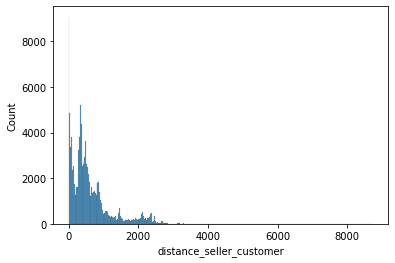

In [45]:
sns.histplot(matching_geo['distance_seller_customer'])

In [46]:
# Checking median distance
matching_geo['distance_seller_customer'].describe()

count    112759.000000
mean        597.030407
std         591.324341
min           0.000000
25%         183.920323
50%         431.879669
75%         791.814412
max        8736.947618
Name: distance_seller_customer, dtype: float64

In [47]:
# Since an order can have multiple sellers, return the average distance per order
mean_order_distance = matching_geo.groupby("order_id", as_index=False).agg(
    {"distance_seller_customer": "mean"}
)
mean_order_distance

,order_id,distance_seller_customer
0,00010242fe8c5a6d1ba2dd792cb16214,301.005664
1,00018f77f2f0320c557190d7a144bdd3,589.274140
2,000229ec398224ef6ca0657da4fc703e,312.495046
3,00024acbcdf0a6daa1e931b038114c75,301.951753
4,00042b26cf59d7ce69dfabb4e55b4fd9,646.221788
...,...,...
98172,fffc94f6ce00a00581880bf54a75a037,2755.314485
98173,fffcd46ef2263f404302a634eb57f7eb,354.848852
98174,fffce4705a9662cd70adb13d4a31832d,338.827218
98175,fffe18544ffabc95dfada21779c9644f,72.870476


In [48]:
mean_order_distance.describe()

,distance_seller_customer
count,98177.000000
mean,601.961534
std,596.877838
min,0.000000
25%,186.380313
50%,433.698770
75%,798.435455
max,8736.947618


#### Implement logic in `order.py`

In [49]:
# Checking
Order().get_distance_seller_customer()

,order_id,distance_seller_customer
0,00010242fe8c5a6d1ba2dd792cb16214,301.005664
1,00018f77f2f0320c557190d7a144bdd3,589.274140
2,000229ec398224ef6ca0657da4fc703e,312.495046
3,00024acbcdf0a6daa1e931b038114c75,301.951753
4,00042b26cf59d7ce69dfabb4e55b4fd9,646.221788
...,...,...
98172,fffc94f6ce00a00581880bf54a75a037,2755.314485
98173,fffcd46ef2263f404302a634eb57f7eb,354.848852
98174,fffce4705a9662cd70adb13d4a31832d,338.827218
98175,fffe18544ffabc95dfada21779c9644f,72.870476


## get_training_data()

### Implement get_training_data() in `orders.py`

In [52]:
# Test function
from olistdash.order import Order
Order().get_training_data()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...
97010,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08
97011,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10
97012,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02
97013,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18


# END OF THIS NOTEBOOK